# Finalized Data Preprocessing and Model Creation

In [1]:
!pip3 install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.


## Data Preprocessing

In [2]:
# for data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import yfinance as yf
from sklearn import linear_model
# Split later
from sklearn.linear_model import ARDRegression, LinearRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, accuracy_score, recall_score
from sklearn.preprocessing import PolynomialFeatures
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from keras.optimizers import SGD

2024-03-10 17:00:40.137531: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[*********************100%%**********************]  1 of 1 completed


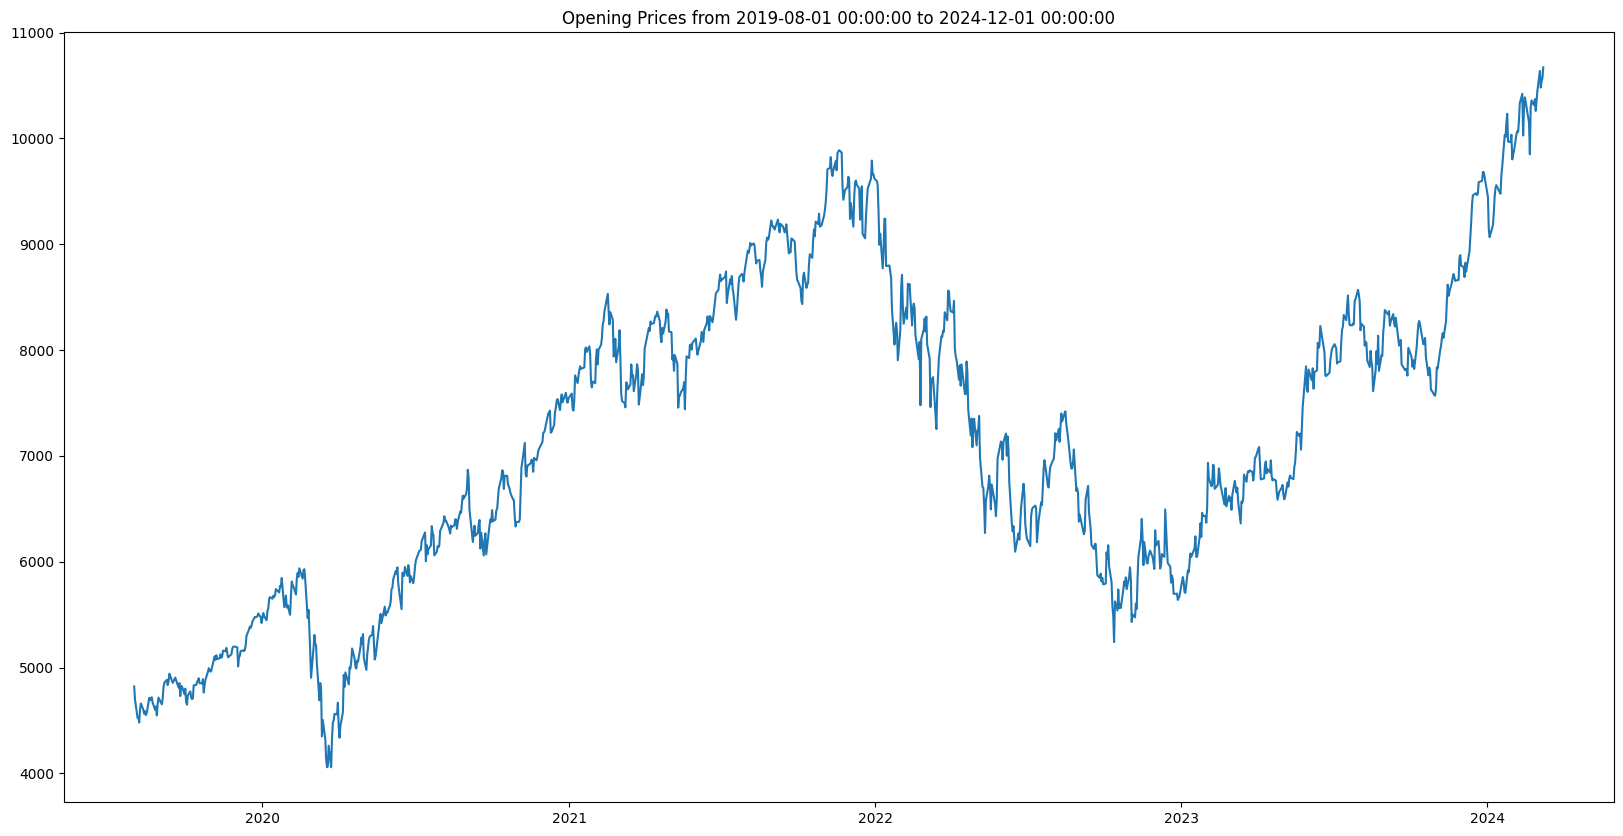

In [3]:
# initialize parameters 
start_date = datetime(2019, 8, 1)
end_date = datetime(2024, 12, 1)

# get the data 
stock_data = yf.download('^NDXT', start = start_date,
                         end = end_date)

stock_data.to_csv('stock_data.csv', index = True, encoding='utf-8') # False: not include index

# display 
plt.figure(figsize = (20,10))
plt.title('Opening Prices from {} to {}'.format(start_date,
                                                end_date))
plt.plot(stock_data['Open'])
plt.show()

In [4]:
def date_to_index(stock_data, date):
    date_col_stock_data = stock_data.index.to_pydatetime()
    for i in range(len(date_col_stock_data)):
        if date_col_stock_data[i] == date:
            return i
    return -1

def get_closest_available_date(stock_data, date):
    date_col_stock_data = stock_data.index.to_pydatetime()
    # date_col_stock_data = stock_data.reset_index()['Date']
    while date not in date_col_stock_data:
        date = date - timedelta(days = 1)
    return date

"""
@param stock_data: original stock_data df
@param week_end: layoff date
@param period: number of days to look back, defaults to 7

@return % of change in NDXT index price during last week before layoff date 
"""
def weekly_price_diff(stock_data, week_end, period: int = 7):
    # week end date in format datetime(YYYY,MM,DD)

    if (week_end < datetime(2020, 1, 15)):
        return 0
    date_col_stock_data = stock_data.reset_index() # add DATE as column
    date_end_closest = get_closest_available_date(stock_data, week_end)
    date_start_closest = get_closest_available_date(stock_data, week_end - timedelta(days = period))

    price_end = stock_data['Open'][date_end_closest]
    price_start = stock_data['Open'][date_start_closest]
    price_diff = (price_end - price_start) / price_start * 100

    return price_diff # in PERCENTAGE

# ! USAGE EXAMPLE
price_diff = weekly_price_diff(stock_data, datetime(2022, 4, 11))
price_diff = round(price_diff, 2)
print(f"Diff between 11 APR 2022 and week before: {price_diff}%")

Diff between 11 APR 2022 and week before: -7.59%


In [5]:
# TODO: ADD RETRIEVED STOCK CHANGE TO DATA_PD

week_price_diff_df = pd.DataFrame(index = stock_data.index, columns = ['price_diff'])
for date in week_price_diff_df.index:
    week_price_diff_df.loc[date, 'price_diff'] = weekly_price_diff(stock_data, date)

stock_data['price_diff'] = week_price_diff_df['price_diff']
stock_data.to_csv('stock_data.csv', index = True, encoding='utf-8')
stock_data

,Open,High,Low,Close,Adj Close,Volume,price_diff
Date,,,,,,,
2019-08-01,4821.149902,4924.919922,4726.339844,4762.810059,4762.810059,425800,0
2019-08-02,4695.549805,4712.990234,4629.250000,4655.560059,4655.560059,356000,0
2019-08-05,4525.939941,4534.649902,4434.459961,4469.970215,4469.970215,427900,0
2019-08-06,4530.689941,4562.890137,4481.229980,4531.810059,4531.810059,317500,0
2019-08-07,4480.180176,4563.459961,4470.759766,4550.560059,4550.560059,321600,0
...,...,...,...,...,...,...,...
2024-03-04,10638.120117,10670.769531,10579.769531,10606.419922,10606.419922,0,3.143825
2024-03-05,10480.400391,10489.519531,10255.240234,10332.759766,10332.759766,0,1.055839
2024-03-06,10542.009766,10566.629883,10407.910156,10475.540039,10475.540039,0,2.747636


In [6]:
def str_to_datetime(dt_string):
    return datetime.strptime(dt_string, "%Y-%m-%d %H:%M:%S UTC")

layoff_data = pd.read_csv("tech_layoffs.csv")

layoff_data["Date_layoffs"] = layoff_data["Date_layoffs"].apply(lambda x: str_to_datetime(x))
layoff_data['Company'] = layoff_data['Company'].replace({'SaleSan Franciscoorce': 'Salesforce'})
layoff_data.set_index('Date_layoffs', inplace = True)
layoff_data = layoff_data.sort_index()
layoff_data = layoff_data[layoff_data['Continent'] == 'North America']
layoff_data = layoff_data[layoff_data['Country'] == 'USA']
layoff_data = layoff_data[layoff_data['Company_Size_before_Layoffs'] >= 10]
layoff_data = layoff_data.drop(columns=["Company", "lat", "lng", "Continent", "Country", "#"])

cities_by_timezone = {
    'Pacific Time': ['Los Angeles', 'San Francisco Bay Area', 'Seattle', 'Portland', 'San Luis Obispo', 'Sacramento', 'San Diego', 'Santa Barbara', 'Camarillo', 'Fremont', 'Bend', 'Reno', 'Spokane', 'Las Vegas', 'Fresno'],
    'Mountain Time': ['Denver', 'Boulder', 'Salt Lake City', 'Missoula', 'Santa Fe', 'Phoenix', 'Lehi', 'Logan', 'Boise'],
    'Central Time': ['Austin', 'Chicago', 'Minneapolis', 'Milwaukee', 'Nashville', 'Dallas', 'Cincinnati', 'Columbus', 'Indianapolis', 'Nebraska City', 'Kansas City'],
    'Eastern Time': ['New York City', 'Boston', 'Atlanta', 'Ann Arbor', 'Miami', 'Detroit', 'Stamford', 'Washington DC', 'Philadelphia', 'Raleigh', 'Walnut', 'Madison', 'Dover', 'Burlington', 'Wilmington', 'Nashua', 'Baltimore', 'Tampa Bay']
}

def get_timezone(city):
    for timezone, cities in cities_by_timezone.items():
        if city in cities:
            return timezone
    return None

# Assign new attribute 'Timezone' based on city
layoff_data['Region'] = layoff_data['Location_HQ'].map(get_timezone)
layoff_data = layoff_data.drop(columns=["Location_HQ", "Company_Size_after_layoffs", "Laid_Off"]) 

#Incorporate stock price
layoff_data = layoff_data.reset_index()

#Create a new column for stock price change, and add it to the layoff_data_with_date_col dataframe
layoff_data.insert(1, "stock_delta", layoff_data["Date_layoffs"].apply(lambda x: weekly_price_diff(stock_data, x, period=90)))
layoff_data  # bug: several stock_delta values are 0, which is highly improbable.


industry_encoder = LabelEncoder()
layoff_data['industry_encoded'] = industry_encoder.fit_transform(layoff_data['Industry'])

time_encoder = LabelEncoder()
layoff_data['Region_encoded'] = industry_encoder.fit_transform(layoff_data['Region'])

# Create LabelEncoder instance for stage column
stage_encoder = LabelEncoder()
layoff_data['stage_encoded'] = stage_encoder.fit_transform(layoff_data['Stage'])
layoff_data = layoff_data.drop(columns=["Industry", "Stage","Year","Region"])
layoff_data['Money_Raised_in_$_mil'] = layoff_data['Money_Raised_in_$_mil'].str.replace('$', '').astype(float) * 1000000

#convert date layoffs to unix
layoff_data['Date_layoffs'] = layoff_data['Date_layoffs'].apply(lambda x: int(datetime.timestamp(x)))


Y = layoff_data['Percentage']

# layoff_data = layoff_data.drop(columns=["Date_layoffs"])

industry = layoff_data['industry_encoded']
stage = layoff_data['stage_encoded'] 
region = layoff_data['Region_encoded']

# Reshape to a 2D array
industry = industry.values.reshape(-1, 1)
stage = stage.values.reshape(-1, 1)
region = region.values.reshape(-1, 1)

# #display
# display(layoff_data)


# One-hot encode
encoder = OneHotEncoder(sparse_output=False, drop='first')
industry_onehot = encoder.fit_transform(industry)
encoder = OneHotEncoder(sparse_output=False, drop='first')
stage_onehot = encoder.fit_transform(stage)
encoder = OneHotEncoder(sparse_output=False, drop='first')
region_onehot = encoder.fit_transform(region)

# Display the one-hot encoded arrays

# Drop the original categorical columns from layoff_data
layoff_data = layoff_data.drop(columns=["industry_encoded", "stage_encoded", "Region_encoded"])
layoff_data = layoff_data.drop(columns=["Percentage"])
display(layoff_data)

# Concatenate numerical features and one-hot encoded features
data_array = np.hstack((layoff_data.values, industry_onehot, stage_onehot, region_onehot))

X = data_array

print(X.shape)
print(Y.shape)

,Date_layoffs,stock_delta,Company_Size_before_Layoffs,Money_Raised_in_$_mil
0,1583996400,-17.938421,50,90000000.0
1,1584082800,-15.003683,80,45000000.0
2,1584342000,-19.758224,591,79000000.0
3,1584342000,-19.758224,16,6000000.0
4,1584514800,-24.824380,20,4000000.0
...,...,...,...,...
897,1704873600,14.204551,188000,26000000.0
898,1704873600,14.204551,450,57000000.0
899,1704960000,15.684460,1000,995000000.0
900,1704960000,15.684460,2000,14000000.0


(902, 51)
(902,)


In [7]:
print(X.shape)
print(Y.shape)

(902, 51)
(902,)


In [8]:
# Assuming you have already defined X and Y

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Print the shapes of the resulting sets
print("Training set shapes: X_train =", X_train.shape, ", Y_train =", y_train.shape)
print("Testing set shapes: X_test =", X_test.shape, ", Y_test =", y_test.shape)

Training set shapes: X_train = (721, 51) , Y_train = (721,)
Testing set shapes: X_test = (181, 51) , Y_test = (181,)


In [9]:
# layoff_data.values, industry_onehot, stage_onehot, region_onehot
print("LAYOFF DATA VALS: " + str(layoff_data.values[0]))
print("INDUSTRY ONEHOT: " + str(industry_onehot[0]))
print("STAGE ONEHOT: " + str(stage_onehot[0]))
print("REGION ONEHOT: " + str(region_onehot[0]))

print("X: " + str(X[0]))


LAYOFF DATA VALS: [ 1.5839964e+09 -1.7938421e+01  5.0000000e+01  9.0000000e+07]
INDUSTRY ONEHOT: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0.]
STAGE ONEHOT: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
REGION ONEHOT: [0. 0. 1. 0.]
X: [ 1.5839964e+09 -1.7938421e+01  5.0000000e+01  9.0000000e+07
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  1.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.000

In [10]:
Y

0       40.000000
1       10.000000
2       22.000000
3      100.000000
4       20.000000
          ...    
897      0.531915
898     13.333333
899     17.000000
900      5.000000
901     13.000000
Name: Percentage, Length: 902, dtype: float64

## Polynomial Regression Model

In our first model, we wanted to determine if a polynomial regression model
would work in predicting the percentage of employees that would be laid off.

In [11]:
mse_arr = []

In [12]:
logreg = LinearRegression()

X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_train_df = pd.DataFrame(X_train_np)
y_train_df = pd.DataFrame(y_train_np)

logreg.fit(X_train_df, y_train_df)

yhat_train = logreg.predict(X_train)
yhat_test = logreg.predict(X_test)

MSE_train = np.mean((y_train.values - yhat_train)**2)
MSE_test = np.mean((y_test.values - yhat_test)**2)

mse_arr.append((MSE_train, MSE_test))

print(f"MSE_train: {MSE_train}")
print(f"MSE_test: {MSE_test}")


MSE_train: 484.8927144143581
MSE_test: 409.1260231099857


In [13]:
for k in range(2,5):
    # Create kth degree polynomial
    poly = PolynomialFeatures(k)

    # Convert features to fit polynomial model
    train_features = poly.fit_transform(X_train_df)
    test_features = poly.fit_transform(X_test)

    # Create polynomial regression
    polyreg = LinearRegression()
    polyreg.fit(train_features, y_train_df)

    # Get predictions
    yhat_train = polyreg.predict(train_features)
    yhat_test = polyreg.predict(test_features)

    # Print resulting MSE
    MSE_train = np.mean((y_train.values - yhat_train) ** 2)
    MSE_test = np.mean((y_test.values - yhat_test) ** 2)

    mse_arr.append((MSE_train, MSE_test))

    print(f'Degree: {k}')
    print(f'    MSE_train: {MSE_train}')
    print(f'    MSE_test:  {MSE_test}')

Degree: 2
    MSE_train: 518.5153296495845
    MSE_test:  632.9334458698142
Degree: 3
    MSE_train: 531.731445123736
    MSE_test:  630.7622353132871
Degree: 4
    MSE_train: 455.33360649425777
    MSE_test:  879.7369178182909


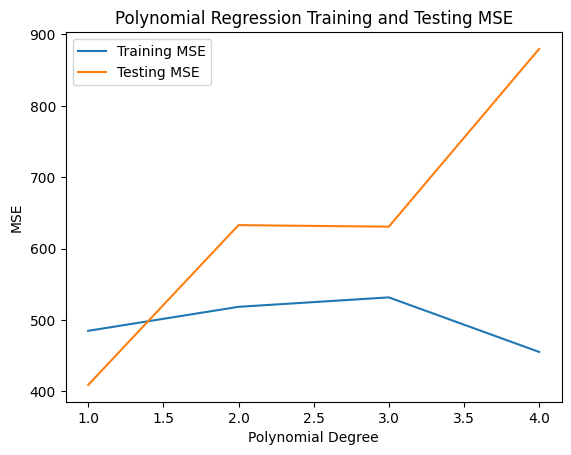

In [14]:
mse_train = [pair[0] for pair in mse_arr]
mse_test = [pair[1] for pair in mse_arr]

degrees = range(1, len(mse_arr) + 1)

plt.plot(degrees, mse_train, label='Training MSE')
plt.plot(degrees, mse_test, label='Testing MSE')

plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('Polynomial Regression Training and Testing MSE')
plt.legend()

plt.show()

### Model 1 Analysis

From our fitting graph, we can conclude from our high MSE that our model is
underfitting regardless of the degree of our polynomial.

For our next two models, we are considering Automatic Relevance Determination
regression and a Neural Network. With ARD regression, we want to see if a
different regularization technique will better assign weights depending on the
feature in our modeling process. Meanwhile, a Neural Network may be better
suited in finding patterns within our data.

### Model 1 Conclusion

From our first model, we can conclude that polynomial regression might not be
the best model to use given our data. The high training and testing MSE along
with the long training times. It is possible that higher polynomial degrees or
isolating some of our input features may improve the performance of our model.
However, we would still run into issues where the polynomial regression takes
a long time to fit with our training data. Thus, we are less likely to use
this in our data.

In [15]:
# layoff_data.values, industry_onehot, stage_onehot, region_onehot
print("LAYOFF DATA VALS: " + str(layoff_data.values[0]))
print("INDUSTRY ONEHOT: " + str(industry_onehot[0]))
print("STAGE ONEHOT: " + str(stage_onehot[0]))
print("REGION ONEHOT: " + str(region_onehot[0]))

print("X: " + str(X[0]))


LAYOFF DATA VALS: [ 1.5839964e+09 -1.7938421e+01  5.0000000e+01  9.0000000e+07]
INDUSTRY ONEHOT: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0.]
STAGE ONEHOT: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
REGION ONEHOT: [0. 0. 1. 0.]
X: [ 1.5839964e+09 -1.7938421e+01  5.0000000e+01  9.0000000e+07
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  1.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.000

In [16]:
Y

0       40.000000
1       10.000000
2       22.000000
3      100.000000
4       20.000000
          ...    
897      0.531915
898     13.333333
899     17.000000
900      5.000000
901     13.000000
Name: Percentage, Length: 902, dtype: float64

# Neural Network

In [17]:
"# Building model, splitting data, fitting model, and predicting points\n",
def build_nn():
    model = Sequential([
        Dense(12, activation='sigmoid', input_dim=51),
        Dense(12, activation='sigmoid'),
        Dense(12, activation='sigmoid'),
        Dense(12, activation='sigmoid'),
        Dense(1, activation='sigmoid'),
    ])
    model.compile(optimizer=SGD(learning_rate=0.1), loss='mse', metrics=['mse'])
    return model

classifier = KerasRegressor(model=build_nn, epochs=100, batch_size=5, verbose=0)
hist = classifier.fit(X_train, y_train)
predictions_test = classifier.predict(X_test)
predictions_train = classifier.predict(X_train)
print('Testing Mean Squared Error:', mean_squared_error(predictions_test, y_test))
print('Training Mean Squared Error:', mean_squared_error(predictions_train, y_train))

Testing Mean Squared Error: 584.9784877869009
Training Mean Squared Error: 786.0688261680176


In [18]:
!pip3 install keras_tuner

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 KB 3.3 MB/s eta 0:00:00
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.


In [19]:
import keras_tuner

In [50]:
import sklearn
import tensorflow as tf
from keras.optimizers import SGD

def buildHPmodel(hp):
  model= Sequential([
      Dense(12, activation = 'sigmoid', input_dim = 51),
      Dense(units=hp.Int("units1", min_value=3, max_value=24, step=5),activation=hp.Choice("acttype", ["sigmoid", "relu", "softmax"])),
      Dense(units=hp.Int("units1", min_value=3, max_value=24, step=5),activation=hp.Choice("acttype", ["sigmoid", "relu", "softmax"])),
      Dense(units=hp.Int("units1", min_value=3, max_value=24, step=5),activation=hp.Choice("acttype", ["sigmoid", "relu", "softmax"])),
      Dense(units=1,activation=hp.Choice("acttype", ["sigmoid", "relu", "softmax"])),
])
  learning_rate = hp.Float("lr", min_value=0.05, max_value=0.3, sampling="log")
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
  return model

In [51]:
tuner = keras_tuner.GridSearch(
    hypermodel=buildHPmodel,
    objective="val_loss",
    directory="tunerStore",
    project_name="tunerInstance3",
    max_trials=50,
    seed=12,
    executions_per_trial=2,
    tune_new_entries=True,
    allow_new_entries=True,
    max_consecutive_failed_trials=3
)

In [52]:
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_test_np = np.array(X_test)
y_test_np = np.array(y_test)

#load from tunerStore trial 48
import keras
model = keras.models.load_model('tunerStore/tunerInstance3/trial_48_model')


"""TO RUN A NEW GRID SEARCH UNCOMMENT THE LINE BELOW"""
# tuner.search(X_train_np, y_train_np, epochs=10, validation_data=(X_test_np, y_test_np), batch_size=15)

Trial 50 Complete [00h 00m 07s]
val_loss: 452.07859802246094

Best val_loss So Far: 277.0343933105469
Total elapsed time: 00h 05m 00s


In [53]:
tuner.results_summary()

Results summary
Results in tunerStore/tunerInstance3
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 48 summary
Hyperparameters:
units1: 8
acttype: relu
lr: 0.06541731153543581
Score: 277.0343933105469

Trial 15 summary
Hyperparameters:
units1: 3
acttype: relu
lr: 0.06541731153543581
Score: 282.6329803466797

Trial 47 summary
Hyperparameters:
units1: 8
acttype: relu
lr: 0.07825422900366437
Score: 283.02598571777344

Trial 13 summary
Hyperparameters:
units1: 3
acttype: relu
lr: 0.0936101501762388
Score: 284.5693817138672

Trial 18 summary
Hyperparameters:
units1: 3
acttype: relu
lr: 0.19168293127388178
Score: 286.58119201660156

Trial 14 summary
Hyperparameters:
units1: 3
acttype: relu
lr: 0.07825422900366437
Score: 287.7265930175781

Trial 45 summary
Hyperparameters:
units1: 8
acttype: relu
lr: 0.11197938216997383
Score: 288.6258850097656

Trial 46 summary
Hyperparameters:
units1: 8
acttype: relu
lr: 0.0936101501762388
Score: 289.4938659667969

Trial 19 summar

In [54]:
models = tuner.get_best_models(num_models=1)
models[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                624       
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 8)                 72        
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 881 (3.44 KB)
Trainable params: 881 (3.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Results from Grid Search
Trial 48 rendered the best predictions, with an MSE of 277, with Trial 15 and 47 coming in second and third respectively.

```Results summary
Results in tunerStore/tunerInstance3
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 48 summary
Hyperparameters:
units1: 8
acttype: relu
lr: 0.06541731153543581
Score: 277.0343933105469

Trial 15 summary
Hyperparameters:
units1: 3
acttype: relu
lr: 0.06541731153543581
Score: 282.6329803466797

Trial 47 summary
Hyperparameters:
units1: 8
acttype: relu
lr: 0.07825422900366437
Score: 283.02598571777344```